# Fine-tuning for Semantic Segmentation with 🤗 Transformers

In this notebook, you'll learn how to fine-tune a pretrained vision model for Semantic Segmentation on a custom dataset in PyTorch. The idea is to add a randomly initialized segmentation head on top of a pre-trained encoder, and fine-tune the model altogether on a labeled dataset. You can find an accompanying blog post [here](https://huggingface.co/blog/fine-tune-segformer). 

## Model

This notebook is built for the [SegFormer model](https://huggingface.co/docs/transformers/model_doc/segformer#transformers.SegformerForSemanticSegmentation) and is supposed to run on any semantic segmentation dataset. You can adapt this notebook to other supported semantic segmentation models such as [MobileViT](https://huggingface.co/docs/transformers/model_doc/mobilevit).

## Data augmentation

This notebook leverages `torchvision`'s [`transforms` module](https://pytorch.org/vision/stable/transforms.html) for applying data augmentation. Using other augmentation libraries like `albumentations` is also [supported](https://github.com/huggingface/notebooks/blob/main/examples/image_classification_albumentations.ipynb).

---

Depending on the model and the GPU you are using, you might need to adjust the batch size to avoid out-of-memory errors. Set those two parameters, then the rest of the notebook should run smoothly.

In this notebook, we'll fine-tune from the https://huggingface.co/nvidia/mit-b0 checkpoint, but note that there are others [available on the hub](https://huggingface.co/models?pipeline_tag=image-segmentation).

In [1]:
model_checkpoint = "nvidia/mit-b0"  # pre-trained model from which to fine-tune
batch_size = 4  # batch size for training and evaluation

Before we start, let's install the `datasets`, `transformers`, and `evaluate` libraries. We also install Git-LFS to upload the model checkpoints to Hub.



In [2]:
!pip -q install datasets transformers evaluate
!pip install torch

!git lfs install
!git config --global credential.helper store

Git LFS initialized.


If you're opening this notebook locally, make sure your environment has an install from the last version of those libraries or run the `pip install` command above with the `--upgrade` flag.

You can share the resulting model with the community. By pushing the model to the Hub, others can discover your model and build on top of it. You also get an automatically generated model card that documents how the model works and a widget that will allow anyone to try out the model directly in the browser. To enable this, you'll need to login to your account.

In [3]:
! pip install -U ipywidgets==7.7.1
from huggingface_hub import notebook_login

notebook_login()

We also quickly upload some telemetry - this tells us which examples and software versions are getting used so we know where to prioritize our maintenance efforts. We don't collect (or care about) any personally identifiable information, but if you'd prefer not to be counted, feel free to skip this step or delete this cell entirely.

In [4]:
from transformers.utils import send_example_telemetry

send_example_telemetry("semantic_segmentation_notebook", framework="pytorch")

## Fine-tuning a model on a semantic segmentation task

Given an image, the goal is to associate each and every pixel to a particular category (such as table). The screenshot below is taken from a [SegFormer fine-tuned on ADE20k](https://huggingface.co/nvidia/segformer-b0-finetuned-ade-512-512) - try out the inference widget!

<img src="https://i.ibb.co/8B8xy1R/image.png" alt="drawing" width="600"/>

### Loading the dataset

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library to download our custom dataset into a [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict).

We're using the Sidewalk dataset which is dataset of sidewalk images gathered in Belgium in the summer of 2021. You can learn more about the dataset [here](https://huggingface.co/datasets/segments/sidewalk-semantic).

In [5]:
from datasets import load_dataset

hf_dataset_identifier = "segments/sidewalk-semantic"
ds = load_dataset(hf_dataset_identifier)

Let us also load the Mean IoU metric, which we'll use to evaluate our model both during and after training. 

IoU (short for Intersection over Union) tells us the amount of overlap between two sets. In our case, these sets will be the ground-truth segmentation map and the predicted segmentation map. To learn more, you can check out [this article](https://learnopencv.com/intersection-over-union-iou-in-object-detection-and-segmentation/).

In [6]:
import evaluate

metric = evaluate.load("mean_iou")

The `ds` object itself is a `DatasetDict`, which contains one key per split (in this case, only "train" for a training split).

In [7]:
ds

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 1000
    })
})

Here, the `features` tell us what each example is consisted of:

* `pixel_values`: the actual image
* `label`: segmentation mask



To access an actual element, you need to select a split first, then give an index:

Found existing installation: pillow 11.1.0
Uninstalling pillow-11.1.0:
  Successfully uninstalled pillow-11.1.0
  Using cached pillow-11.1.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (9.1 kB)
Using cached pillow-11.1.0-cp312-cp312-manylinux_2_28_x86_64.whl (4.5 MB)


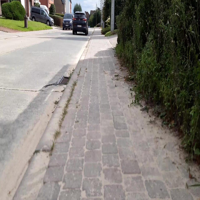

In [8]:
!pip uninstall -y pillow
!pip install -U pillow image

example = ds["train"][10]
example["pixel_values"].resize((200, 200))

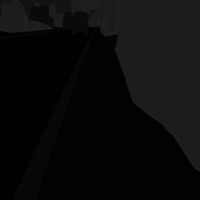

In [9]:
example["label"].resize((200, 200))

Each of the pixels above can be associated to a particular category. Let's load all the categories that are associated with the dataset. Let's also create an `id2label` dictionary to decode them back to strings and see what they are. The inverse `label2id` will be useful too, when we load the model later.

In [10]:
from huggingface_hub import hf_hub_download
import json

filename = "id2label.json"
id2label = json.load(
    open(hf_hub_download(hf_dataset_identifier, filename, repo_type="dataset"), "r")
)
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

num_labels = len(id2label)

id2label.json:   0%|          | 0.00/852 [00:00<?, ?B/s]

In [11]:
num_labels, list(label2id.keys())

(35,
 ['unlabeled',
  'flat-road',
  'flat-sidewalk',
  'flat-crosswalk',
  'flat-cyclinglane',
  'flat-parkingdriveway',
  'flat-railtrack',
  'flat-curb',
  'human-person',
  'human-rider',
  'vehicle-car',
  'vehicle-truck',
  'vehicle-bus',
  'vehicle-tramtrain',
  'vehicle-motorcycle',
  'vehicle-bicycle',
  'vehicle-caravan',
  'vehicle-cartrailer',
  'construction-building',
  'construction-door',
  'construction-wall',
  'construction-fenceguardrail',
  'construction-bridge',
  'construction-tunnel',
  'construction-stairs',
  'object-pole',
  'object-trafficsign',
  'object-trafficlight',
  'nature-vegetation',
  'nature-terrain',
  'sky',
  'void-ground',
  'void-dynamic',
  'void-static',
  'void-unclear'])

**Note**: This dataset specificaly sets the 0th index as being `unlabeled`. We want to take this information into consideration while computing the loss. Specifically, we'll want to mask the pixels where the network predicted `unlabeled` and avoid computing the loss for it since it doesn't contribute to to training that much.

Let's shuffle the dataset and split the dataset in a train and test set. We'll explicitly define a random seed to use when calling `ds.shuffle()` to ensure our results are the same each time we run this cell.

In [12]:
ds = ds.shuffle(seed=1)
ds = ds["train"].train_test_split(test_size=0.2)
train_ds = ds["train"]
test_ds = ds["test"]

### Preprocessing the data

Before we can feed these images to our model, we need to preprocess them. 

Preprocessing images typically comes down to (1) resizing them to a particular size (2) normalizing the color channels (R,G,B) using a mean and standard deviation. These are referred to as **image transformations**.

To make sure we (1) resize to the appropriate size (2) use the appropriate image mean and standard deviation for the model architecture we are going to use, we instantiate what is called a feature extractor with the `AutoFeatureExtractor.from_pretrained` method.

This feature extractor is a minimal preprocessor that can be used to prepare images for model training and inference.

In [13]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)
feature_extractor

preprocessor_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

/home/emiliano/semantic-transformer/lib/python3.12/site-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/home/emiliano/semantic-transformer/lib/python3.12/site-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `SegformerFeatureExtractor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


SegformerFeatureExtractor {
  "do_normalize": true,
  "do_reduce_labels": false,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "SegformerFeatureExtractor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 512,
    "width": 512
  }
}

In [15]:
!pip install torchvision

from torchvision.transforms import ColorJitter
from transformers import SegformerFeatureExtractor

feature_extractor = SegformerFeatureExtractor()
jitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1)

def train_transforms(example_batch):
    images = [jitter(x) for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = feature_extractor(images, labels)
    return inputs


def val_transforms(example_batch):
    images = [x for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = feature_extractor(images, labels)
    return inputs


# Set transforms
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 5.6 MB/s eta 0:00:00 MB/s eta 0:00:01:01m


/home/emiliano/semantic-transformer/lib/python3.12/site-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(


We also defined some data augmentations to make our model more resilient to different lighting conditions. We used the [`ColorJitter`](https://pytorch.org/vision/main/generated/torchvision.transforms.ColorJitter.html) function from `torchvision` to randomly change the brightness, contrast, saturation, and hue of the images in the batch. 

Also, notice the differences in between transformations applied to the train and test splits. We're only applying jittering to the training split and not to the test split. Data augmentation is usually a training-only step and isn't applied during evaluation. 

### Training the model

Now that our data is ready, we can download the pretrained model and fine-tune it. We will use the `SegformerForSemanticSegmentation` class. Calling the `from_pretrained` method on it will download and cache the weights for us. As the label ids and the number of labels are dataset dependent, we pass `label2id`, and `id2label` alongside the `model_checkpoint` here. This will make sure a custom segmentation head is created (with a custom number of output neurons).

In [16]:
from transformers import SegformerForSemanticSegmentation


model = SegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,  # Will ensure the segmentation specific components are reinitialized.
)

config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/14.4M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/14.3M [00:00<?, ?B/s]

The warning is telling us we are throwing away some weights (the weights and bias of the `decode_head` layer) and randomly initializing some other (the weights and bias of a new `decode_head` layer). This is expected in this case, because we are adding a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

To fine-tune the model, we'll use Hugging Face's [Trainer API](https://huggingface.co/docs/transformers/main_classes/trainer). To use the `Trainer`, we'll need to define the training configuration and any evaluation metrics we might want to use.

First, we'll set up the [`TrainingArguments`](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments). This defines all training hyperparameters, such as learning rate and the number of epochs, frequency to save the model and so on. We also specify to push the model to the hub after training (`push_to_hub=True`) and specify a model name (`hub_model_id`).

In [19]:
!pip install transformers[torch]
!pip install accelerate>=0.26.0

from transformers import TrainingArguments

epochs = 50
lr = 0.00006
batch_size = 2

hub_model_id = "segformer-b0-finetuned-segments-sidewalk-2"

training_args = TrainingArguments(
    "segformer-b0-finetuned-segments-sidewalk-outputs",
    learning_rate=lr,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_total_limit=3,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=20,
    eval_steps=20,
    logging_steps=1,
    eval_accumulation_steps=5,
    load_best_model_at_end=True,
    push_to_hub=True,
    hub_model_id=hub_model_id,
    hub_strategy="end",
)

ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.26.0`: Please run `pip install transformers[torch]` or `pip install 'accelerate>=0.26.0'`

Next, we'll define a function that computes the evaluation metric we want to work with. Because we're doing semantic segmentation, we'll use the [mean Intersection over Union (mIoU)](https://huggingface.co/spaces/evaluate-metric/mean_iou), which is directly accessible in the [`evaluate` library](https://huggingface.co/docs/evaluate/index). IoU represents the overlap of segmentation masks. Mean IoU is the average of the IoU of all semantic classes. Take a look at [this blogpost](https://www.jeremyjordan.me/evaluating-image-segmentation-models/) for an overview of evaluation metrics for image segmentation.

Because our model outputs logits with dimensions height/4 and width/4, we have to upscale them before we can compute the mIoU.

In [ ]:
import torch
from torch import nn
import evaluate

metric = evaluate.load("mean_iou")

def compute_metrics(eval_pred):
  with torch.no_grad():
    logits, labels = eval_pred
    logits_tensor = torch.from_numpy(logits)
    # scale the logits to the size of the label
    logits_tensor = nn.functional.interpolate(
        logits_tensor,
        size=labels.shape[-2:],
        mode="bilinear",
        align_corners=False,
    ).argmax(dim=1)

    pred_labels = logits_tensor.detach().cpu().numpy()
    # currently using _compute instead of compute
    # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
    metrics = metric._compute(
            predictions=pred_labels,
            references=labels,
            num_labels=len(id2label),
            ignore_index=0,
            reduce_labels=feature_extractor.reduce_labels,
        )

    # add per category metrics as individual key-value pairs
    per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
    per_category_iou = metrics.pop("per_category_iou").tolist()

    metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
    metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

    return metrics


Finally, we can instantiate a `Trainer` object.



In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer=feature_extractor,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

Notice that we're passing `feature_extractor` to the `Trainer`. This will ensure the feature extractor is also uploaded to the Hub along with the model checkpoints.

Now that our trainer is set up, training is as simple as calling the train function. We don't need to worry about managing our GPU(s), the trainer will take care of that.

In [ ]:
trainer.train()

When we're done with training, we can push our fine-tuned model to the Hub.

This will also automatically create a model card with our results. We'll supply some extra information in kwargs to make the model card more complete.

In [ ]:
kwargs = {
    "tags": ["vision", "image-segmentation"],
    "finetuned_from": pretrained_model_name,
    "dataset": hf_dataset_identifier,
}

trainer.push_to_hub(**kwargs)

## Inference

Now comes the exciting part -- using our fine-tuned model! In this section, we'll show how you can load your model from the hub and use it for inference. 

However, you can also try out your model directly on the Hugging Face Hub, thanks to the cool widgets powered by the [hosted inference API](https://api-inference.huggingface.co/docs/python/html/index.html). If you pushed your model to the Hub in the previous step, you should see an inference widget on your model page. You can add default examples to the widget by defining example image URLs in your model card. See [this model card](https://huggingface.co/segments-tobias/segformer-b0-finetuned-segments-sidewalk/blob/main/README.md) as an example.

<figure class="image table text-center m-0 w-full">
    <video 
        alt="The interactive widget of the model"
        style="max-width: 70%; margin: auto;"
        autoplay loop autobuffer muted playsinline
    >
      <source src="assets/56_fine_tune_segformer/widget.mp4" poster="assets/56_fine_tune_segformer/widget-poster.png" type="video/mp4">
  </video>
</figure>

### Use the model from the Hub

We'll first load the model from the Hub using `SegformerForSemanticSegmentation.from_pretrained()`.

In [ ]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation

feature_extractor = SegformerFeatureExtractor.from_pretrained(model_checkpoint)
hf_username = "segments-tobias"
model = SegformerForSemanticSegmentation.from_pretrained(f"{hf_username}/{hub_model_id}")

Next, we'll load an image from our test dataset and its associated ground truth segmentation label.

In [ ]:
image = test_ds[0]['pixel_values']
gt_seg = test_ds[0]['label']
image

To segment this test image, we first need to prepare the image using the feature extractor. Then we'll forward it through the model.

We also need to remember to upscale the output logits to the original image size. In order to get the actual category predictions, we just have to apply an `argmax` on the logits.

In [ ]:
from torch import nn

inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)

# First, rescale logits to original image size
upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1], # (height, width)
    mode='bilinear',
    align_corners=False
)

# Second, apply argmax on the class dimension
pred_seg = upsampled_logits.argmax(dim=1)[0]

Now it's time to display the result. The next cell defines the colors for each category, so that they match the "category coloring" on Segments.ai.

In [ ]:
#@title `def sidewalk_palette()`

def sidewalk_palette():
    """Sidewalk palette that maps each class to RGB values."""
    return [
        [0, 0, 0],
        [216, 82, 24],
        [255, 255, 0],
        [125, 46, 141],
        [118, 171, 47],
        [161, 19, 46],
        [255, 0, 0],
        [0, 128, 128],
        [190, 190, 0],
        [0, 255, 0],
        [0, 0, 255],
        [170, 0, 255],
        [84, 84, 0],
        [84, 170, 0],
        [84, 255, 0],
        [170, 84, 0],
        [170, 170, 0],
        [170, 255, 0],
        [255, 84, 0],
        [255, 170, 0],
        [255, 255, 0],
        [33, 138, 200],
        [0, 170, 127],
        [0, 255, 127],
        [84, 0, 127],
        [84, 84, 127],
        [84, 170, 127],
        [84, 255, 127],
        [170, 0, 127],
        [170, 84, 127],
        [170, 170, 127],
        [170, 255, 127],
        [255, 0, 127],
        [255, 84, 127],
        [255, 170, 127],
    ]

The next function overlays the output segmentation map on the original image.

In [ ]:
import numpy as np

def get_seg_overlay(image, seg):
  color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
  palette = np.array(sidewalk_palette())
  for label, color in enumerate(palette):
      color_seg[seg == label, :] = color

  # Show image + mask
  img = np.array(image) * 0.5 + color_seg * 0.5
  img = img.astype(np.uint8)

  return img

We'll display the result next to the ground-truth mask.

In [ ]:
import matplotlib.pyplot as plt

pred_img = get_seg_overlay(image, pred_seg)
gt_img = get_seg_overlay(image, np.array(gt_seg))

f, axs = plt.subplots(1, 2)
f.set_figheight(30)
f.set_figwidth(50)

axs[0].set_title("Prediction", {'fontsize': 40})
axs[0].imshow(pred_img)
axs[1].set_title("Ground truth", {'fontsize': 40})
axs[1].imshow(gt_img)

What do you think? Would you send our pizza delivery robot on the road with this segmentation information?

The result might not be perfect yet, but we can always expand our dataset to make the model more robust. We can now also go train a larger SegFormer model, and see how it stacks up. If you want to explore further beyond this notebook, here are some things you can try next:

* Train the model for longer. 
* Try out the different segmentation-specific training augmentations from libraries like [`albumentations`](https://albumentations.ai/docs/getting_started/mask_augmentation/). 
* Try out a larger variant of the SegFormer model family or try an entirely new model family like MobileViT. 